<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

# Scaling an aircraft concept with ADRpy - the turn constraint

Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving *scale* to the concept.

The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the final aeroplane we will progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.

Here we look at the boundary associated with the **sustained level turn constraint.**

<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/img/turn.png" width="20%" align="left">

$\,\,\,$Forces in a turn (background image of an Aerostar R40 Festival by A Sóbester).

### T/W required for sustaining a load factor *n*

Writing the balance of forces on the basis of the diagram above:

$$T-D=0$$
$$L\,\mathrm{cos}\phi-W=0$$
$$L\,\mathrm{sin}\phi-\frac{W}{g}\frac{V^2}{R_\mathrm{turn}}=0$$

Note: the $V$ in the equation above is *true airspeed* (TAS), as this is an inertial term and the inertia is, of course, entirely independent of ambient air density (we are assuming zero wind).

From the first equation, breaking the drag down in the usual way (parabolic drag assumption):

$$T = D = qSC_{\mathrm{D}\mathrm{tot}} = qS\left[C_{\mathrm{D}\mathrm{min}}+C_\mathrm{ind}\right] = qS\left[C_{\mathrm{D}\mathrm{min}}+kC_\mathrm{L}^2\right]$$

We define the *load factor* $n$ as the ratio of the lift and the weight (n=1 in steady, level flight), so $L = nW = qSC_\mathrm{L}$. From the force balance above, $n=1/\mathrm{cos}\,\phi$.

$$T = D = qS\left[C_{\mathrm{D}\mathrm{min}}+k\left(\frac{nW}{qS}\right)^2\right]$$

$$\frac{T}{W}=q\left[\frac{C_\mathrm{Dmin}}{(W/S)} + k\left(\frac{n}{q}\right)^2\left(\frac{W}{S}\right)\right]$$

Some additional, useful relationships that can be derived from the above force balance...

$$R_\mathrm{turn} = \frac{WV^2}{gL\sin\theta} = \frac{V^2}{gn\sin\theta} = \frac{V^2}{g\tan\theta}$$ or $$R_\mathrm{turn} = \frac{V^2}{g\sqrt{n^2-1}} $$

Note: From the lift required from the wing to accomplish the turn $L = nW = qSC_\mathrm{L}$, we can calculate the required lift coefficient: $C_\mathrm{L} = n\,(W/S)\,/q$. Of course, increasing the lift coefficient in the turn is only feasible by increasing the angle of attack, thus getting closer to the clean $C_\mathrm{L}^\mathrm{max}$. This means that there comes a point (at the higher end of the W/S scale) where the wing will not be able to generate the required lift (it will have reached its critical alpha), regardless of the amount of excees thrust available. You thus need to not only compute the T/W for a range of wing loadings, but also check that the required lift coefficient does not exceed $C_\mathrm{L}^\mathrm{max}$.

Have a look 'under the hood'of `thrusttoweight_sustainedturn` to see how this done and how the equations above are implemented. Also, see the higher level turn constraint function `twrequired_trn`, which returns a `feasibletw`, a list of thrust to weight ratios where those elements corresponding to wings that are too small to carry the required load factor due to the maximum lift coefficient limit are not included.

### Estimating the induced drag

In order to obtain a T/W curve, we need to estimate $k$, defined as:

$$k = \frac{1}{\pi\,AR\,e}$$

With the aspect ratio $AR$ known, we just need to estimate the Oswald span efficiency $e$. There are several approximations for this.

Here is an approximation due to Raymer, for moderate aspect ratios:

$$e=1.78\left(1-0.045\,AR^{0.68}\right)-0.64$$

From Brandt et al, Introduction to Aeronautics -- a Design perspective, AIAA Education Series:

$$e = 2\,\left[2-AR+\sqrt{4+AR^2\left(1+\tan^2\Delta_\mathrm{tmax}\right)}\right]^{-1}$$

where $\Delta_\mathrm{tmax}$ is the sweep angle of the wing at its maximum thickness chord station.

Another approximation due to Raymer, swept wings:

$$e=4.61\left(1-0.045\,AR^{0.68}\right)\,\left(\mathrm{cos}\Delta_\mathrm{LE}\right)^{0.15}-3.1$$

where $\Delta_\mathrm{LE}$ is the leading edge sweep angle.

These equations are implemented separately as `oswaldspaneff1`, `oswaldspaneff2`, `oswaldspaneff3` and integrated in `induceddragfact` in the `AircraftConcept` class (the latter method takes the `whichoswald` argument, where the user can specify whether to use one of the three equations (e.g., `whichoswald=2` for Brandt et al) or average several of them (e.g., `whichoswald=123` yields an average of the three). 

This is demonstrated in the following visual comparison of the three models.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

# Aspect ratio (AR) range to be swept
ar_range = np.arange(3,12,0.1)
e1 = []; e2 = []; e3 = []; e123 = [] 
k1 = []; k2 = []; k3 = []; k123 = []
for ar in ar_range:
    exdesign = {'aspectratio':ar, 'sweep_le_deg': 10, 'sweep_mt_deg': 6}
    experformance = {}
    exconcept = ca.AircraftConcept(brief={}, design=exdesign, performance={}, designatm={})
    k1.append(exconcept.induceddragfact(1))
    k2.append(exconcept.induceddragfact(2))
    k3.append(exconcept.induceddragfact(3))
    k123.append(exconcept.induceddragfact(123))
    e1.append(exconcept.oswaldspaneff1())
    e2.append(exconcept.oswaldspaneff2())
    e3.append(exconcept.oswaldspaneff3())
    e123.append((e1[-1] + e2[-1] + e3[-1]) / 3.0)

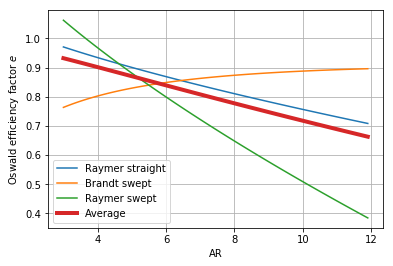

In [3]:
plt.plot(ar_range, e1, label='Raymer straight')
plt.plot(ar_range, e2, label='Brandt swept')
plt.plot(ar_range, e3, label='Raymer swept')
plt.plot(ar_range, e123, label='Average', linewidth = 4)
plt.grid(True)
plt.xlabel('AR')
plt.ylabel('Oswald efficiency factor $e$')
plt.legend()
plt.show()

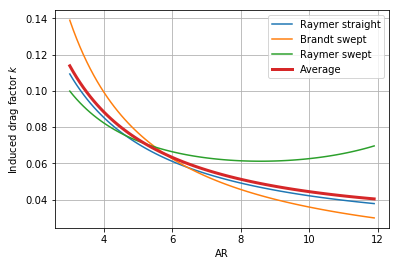

In [5]:
plt.plot(ar_range, k1, label='Raymer straight')
plt.plot(ar_range, k2, label='Brandt swept')
plt.plot(ar_range, k3, label='Raymer swept')
plt.plot(ar_range, k123, label='Average', linewidth = 3)
plt.grid(True)
plt.xlabel('AR')
plt.ylabel('Induced drag factor $k$')
plt.legend()
plt.show()

### Calculating the turn constraint for the business jet example

Let us return to the business jet example we introduced in the take-off performance notebok. We start with the usual preamble:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at
from ADRpy import unitconversions as co

We specify the design brief, the high level design variables and the performance estimates of the tentative design, as well as the atmosphere we will be working with (see the [documentation](https://adrpy.readthedocs.io/en/latest/#constraintanalysis.AircraftConcept) on setting up a new aircraft concept); we then set up the aircraft concept object (note the new dictionary entries, including the sweep required for the Oswald efficiency estimates):

In [8]:
designbrief = {'rwyelevation_m':1000, 'groundrun_m':1200, 'stloadfactor': 2, 'turnalt_m': 5000, 'turnspeed_ktas': 300}
designdefinition = {'aspectratio':7.3, 'sweep_le_deg':10, 'sweep_mt_deg':8, 'bpr':3.9, 'tr':1.05} 
designperformance = {'CDTO':0.04, 'CLTO':0.9, 'CLmaxTO':1.6, 'mu_R':0.02, 'CDminclean':0.02}

designatm = at.Atmosphere()

concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm)

The wing loading range relevant to the class of design (business jet) we are working with:

In [9]:
wingloadinglist_pa = np.arange(2000, 5000, 10)

We are now ready to calculate the basic T/W (note that you would not normally call this calculation, as there is a more user-friendly, all-in-one wrapper for this called `twrequired_trn`, but here we break out the various steps):

In [10]:
twratio, clrequired = concept.thrusttoweight_sustainedturn(wingloadinglist_pa)

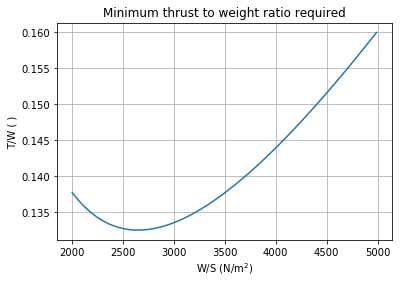

In [11]:
plt.plot(wingloadinglist_pa, twratio)
plt.ylabel("T/W ( )")
plt.xlabel("W/S (N/m$^2$)")
plt.title("Minimum thrust to weight ratio required")
plt.grid(True)
plt.show()

In [16]:
temp_c = designatm.airtemp_c(designbrief['turnalt_m'])
pressure_pa = designatm.airpress_pa(designbrief['turnalt_m'])
mach = designatm.mach(co.kts2mps(designbrief['turnspeed_ktas']), designbrief['turnalt_m'])

throttleratio = designdefinition['tr']

correctionvec = []
for tw in twratio:
    twratio_altcorr = at.turbofanthrustfactor(temp_c, pressure_pa, mach, throttleratio, "lowbpr")
    correctionvec.append(twratio_altcorr)
    
twratio1 = twratio / twratio_altcorr

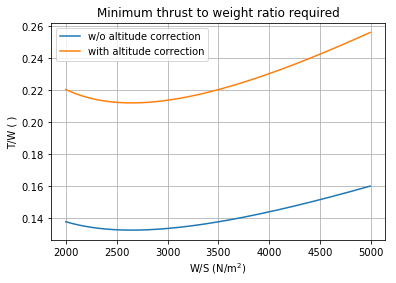

In [17]:
plt.plot(wingloadinglist_pa, twratio, label = 'w/o altitude correction')
plt.plot(wingloadinglist_pa, twratio1, label = 'with altitude correction')

plt.ylabel("T/W ( )")
plt.xlabel("W/S (N/m$^2$)")
plt.title("Minimum thrust to weight ratio required")
plt.grid(True)
plt.legend()
plt.show()

### Sensitivity and uncertainty quantification

Let us now consider an uncertainty quantification example similar to that introuced in the take-off constraint notebook.

In [21]:
twmatrix = []
wingloadinglist_pa = np.arange(2000, 5000, 10)
mc_samplesize = 1000

for i in range(1, mc_samplesize):

    ar = np.random.uniform(6.5, 9)
    bpr = max(5, np.random.normal(8, 1))
    tr = np.random.uniform(1.04, 1.08)

    sle_deg = np.random.normal(17, 3)
    smt_deg = sle_deg - np.random.normal(7, 3)
    
    offs_deg = np.random.normal(15, 15)
    
    cdmin = np.random.normal(0.02, 0.002)
    
    designbrief = {'rwyelevation_m':0, 'groundrun_m':1200, 'stloadfactor': 2, 'turnalt_m': 5000, 'turnspeed_ktas': 300}
    designdefinition = {'aspectratio':ar, 'sweep_le_deg':sle_deg, 'sweep_mt_deg':smt_deg, 'bpr':bpr, 'tr':tr} 
    designperformance = {'CDminclean':cdmin}
    designatm = at.Atmosphere(offset_deg=offs_deg, profile=None)

    concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm)
    tw_sl, _, _ = concept.twrequired_trn(wingloadinglist_pa)
    
    if np.size(twmatrix) > 0:
        twmatrix = np.vstack((twmatrix,tw_sl))
    else:
        twmatrix = tw_sl
    # You can comment this plot out for large samples - it is not 
    # very edifying anyway (included just as a sanity check)
    plt.plot(wingloadinglist_pa, tw_sl)

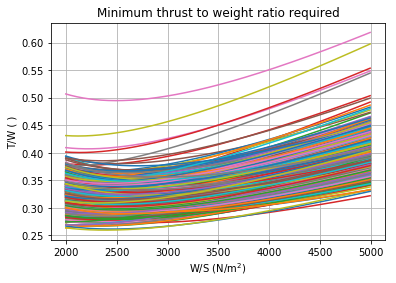

In [22]:
plt.ylabel("T/W ( )")
plt.xlabel("W/S (N/m$^2$)")
plt.title("Minimum thrust to weight ratio required")
plt.grid(True)
plt.show()

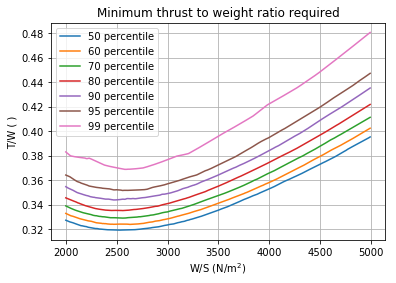

In [23]:
for feasible_percentile in [50, 60, 70, 80, 90, 95, 99]:
    percentile_tw = np.percentile(twmatrix, feasible_percentile, axis=0)
    plt.plot(wingloadinglist_pa, percentile_tw, label = str(feasible_percentile)+' percentile')

legend = plt.legend(loc='upper left')
plt.ylabel("T/W ( )")
plt.xlabel("W/S (N/m$^2$)")
plt.title("Minimum thrust to weight ratio required")
plt.grid(True)
plt.show()